### Forecasting Project - Air Quality

#### EDA

In [1]:
#Importing the required Libraries
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Forecasting Plots
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

#Transformation
from scipy.stats import boxcox 

#Model Based Methods
import statsmodels.formula.api as smf 

#Data Driven Methods
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  #--to ignore warnings

In [2]:
#Loading the Dataset
tsd = pd.read_excel("C:/Users/Akaash/Downloads/CO2 dataset.xlsx")
tsd.head(10)

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542
5,1805.0,0.00536
6,1806.0,0.00529
7,1807.0,0.00523
8,1808.0,0.00517
9,1809.0,0.00511


Inference: The Dataset is loaded, this is our original dataset

In [3]:
#Checking the shape of the Dataset
tsd.shape

(215, 2)

Inference: The Dataset consists of 215 rows & 2 columns, this means there is only one Yt variable corresponding to its time(t) variable

In [4]:
#No of Unique Values
print('No of Unique Values in CO2',len(tsd['CO2'].unique()))
print('No of Unique Values in Year',len(tsd['Year'].unique()))

No of Unique Values in CO2 170
No of Unique Values in Year 215


In [5]:
#Checking for NA Values
tsd.isnull().sum()

Year    0
CO2     0
dtype: int64

Inference: There are no NA Values present in the Dataset

In [6]:
#Checkinng the Dtypes of Column/Variable
tsd.dtypes

Year    float64
CO2     float64
dtype: object

Inference: The "Year" columns i.e our t variable is of Float64 dtype,it should be of datetime dtype,so we will now convert it to datetime

In [7]:
# Converting "Year" column (Yt variable) to datetime
tsd['Year'] = pd.to_datetime(tsd['Year'],format='%Y')
tsd.dtypes

Year    datetime64[ns]
CO2            float64
dtype: object

Inference: Now "Year" column i.e t variable is converted to datetime. So mostly EDA is Done we can Now Move to Descriptive Stats & Visualization Part.

In [8]:
#Date Ranges
print("Minimum Date is :",min(tsd['Year']))
print("Maximum Date is :",max(tsd['Year']))

Minimum Date is : 1800-01-01 00:00:00
Maximum Date is : 2014-01-01 00:00:00


#### Descriptive Stats

In [9]:
#Descritive Stats of the Dataset
tsd.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


Inference: We can see here, Minimum CO2 is 0.0017, Maximum CO2 is 18.2 with Average CO2 of 6.74 & std of 6.522

#### Visualization

In [10]:
#Converting the Year Column into Index For Visualization
tsd1=tsd.set_index(['Year'])
tsd1.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


Inference: Now Dataset is Ready to Visualize


##### Line Plot

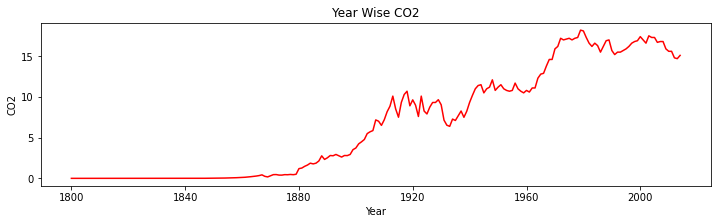

In [11]:
# Line Plot
fig = plt.figure(figsize=(12,3)) 
plt.plot(tsd1, color = 'r')
plt.xlabel('Year')                                      
plt.ylabel('CO2')                                    
plt.title('Year Wise CO2')
plt.show()

Inference: A Line Plot Showing Year wise CO2 Emission,Here we can see Earlier (from the year 1800 to 1860) there was constant trend (A Flat line),After that the Trend started to go up Exponentially.

we can also see there is no sign of seasonality(Fluctuations Changes Drastically over the period of time)

So this Timeseries data has an Exponential Trend with No Seasonal Component

##### Histogram & Density Plots

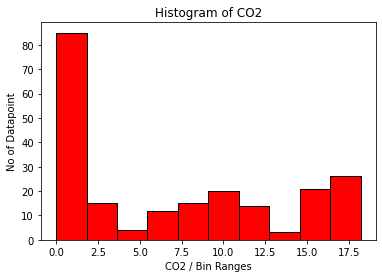

In [12]:
# Histogram
plt.hist(tsd1.CO2, color ='Red',edgecolor ="black")
plt.xlabel('CO2 / Bin Ranges')                                      
plt.ylabel('No of Datapoint')                                    
plt.title('Histogram of CO2')
plt.show()

Inference: The Data is not normally Distribution More Values are Concentrated around 0 to 1.5 CO2 Range

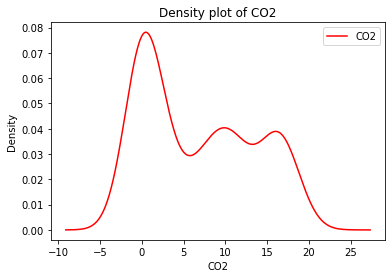

In [13]:
#Density plot
tsd1.plot(kind='kde',color='r')
plt.xlabel('CO2')
plt.title('Density plot of CO2')
plt.show()

Inference: The Data Does Not follow normal distribution,most values are concentrated between 0 to 1.5 range of CO2

##### Lag Plot

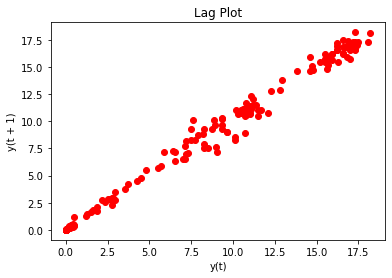

In [14]:
#A Lag Plot
lag_plot(tsd1,c = 'r')
plt.title('Lag Plot')
plt.show()

Inference:There is a Linear Relationship between the Y(t) & Y(t + 1) Variable

##### Correlogram / ACF Plot

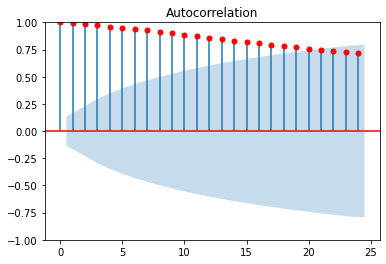

In [15]:
# A autocorrelation plot
plot_acf(tsd1, c ='r')
plt.show()

Inference: This is An Autocorrelation Plot, here we can see the standard Error(SE) ranges from -0.75 to 0.75.

The lag variable which are above the standard error range then those variables are statistically significant

So in Our case the all the  lagged variable are significant except the last four lagged Variable

##### Time series decomposition plot

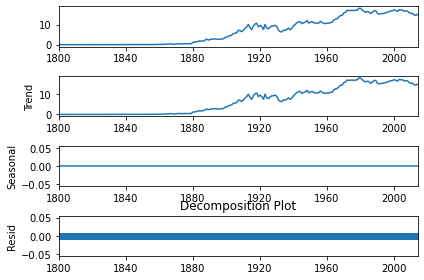

In [16]:
decompose = seasonal_decompose(tsd1)
decompose.plot()
plt.title("Decomposition Plot")
plt.show()

Inference: Now We can say its Confirm there is no Seasonality only Trend 

We Can Visualize it is a Exponential Trend & No Seasonality.

### Model Based Methods

In [17]:
# Creating t & t2 Variable
data = tsd1.copy()
data ["t"] = np.arange(1,216)
data["t_squared"] = data["t"]*data["t"]
data["log_CO2"] = np.log(data['CO2'])
data.head()

,CO2,t,t_squared,log_CO2
Year,,,,
1800-01-01,0.00568,1,1,-5.170804
1801-01-01,0.00561,2,4,-5.183205
1802-01-01,0.00555,3,9,-5.193957
1803-01-01,0.00548,4,16,-5.206650
1804-01-01,0.00542,5,25,-5.217659


#### Transformation
Transforming the TimeSeries to get the Trend Reduce & get Normal Distribution

In [18]:
#Log Transformation
Log_ = pd.DataFrame(data.iloc[:,1:3])
Log_['CO2']=np.log(data['CO2'])
Log_['log_CO2']=np.log(Log_['CO2'])
#Reciprocal Transformation
Reci = pd.DataFrame(data.iloc[:,1:3])
Reci['CO2']=1/(data['CO2'])
Reci['log_CO2']=np.log(Reci['CO2'])
#Square Root Transformation
Sqrt_ = pd.DataFrame(data.iloc[:,1:3])
Sqrt_['CO2']=np.sqrt(data['CO2'])
Sqrt_['log_CO2']=np.log(Sqrt_['CO2'])
#Box-cox Transformation
Box = pd.DataFrame(data.iloc[:,1:3])
Box['CO2'], param = stats.boxcox(data.CO2)
Box['log_CO2']=np.log(Box['CO2'])

Text(0.5, 1.0, 'Box')

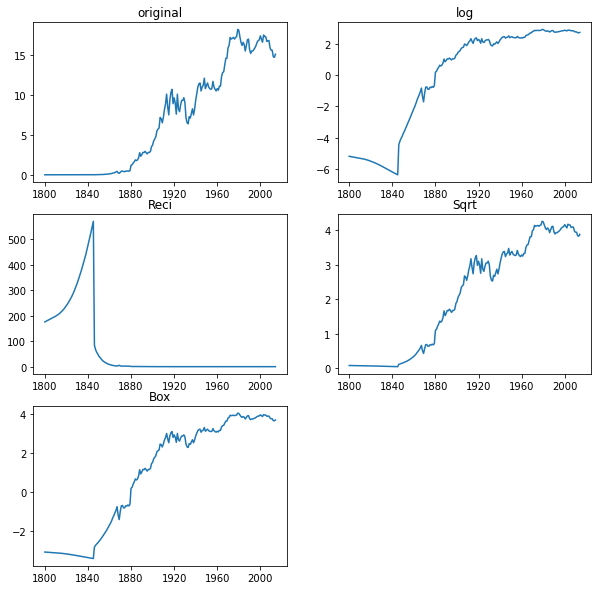

In [19]:
#Ploting the transformed data
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.plot(data.CO2)
plt.title("original")

plt.subplot(322)
plt.plot(Log_.CO2)
plt.title("log")

plt.subplot(323)
plt.plot(Reci.CO2)
plt.title("Reci")

plt.subplot(324)
plt.plot(Sqrt_.CO2)
plt.title("Sqrt")

plt.subplot(325)
plt.plot(Box.CO2)
plt.title("Box")

Inference: From the the Line plot for all the Transformation, we can still see Trend to be present,any transformation made no difference.

So for best practice will make models on all transform data and checks which model gives least error

#### Data Partition
Train - 80% , Test - 20%

In [20]:
#For Original Data
Ori_train = data.iloc[:,:4].head(172)
Ori_test = data.iloc[:,:4].tail(43)
#For Log Data
Log_train = Log_.iloc[:,:4].head(172)
Log_test = Log_.iloc[:,:4].tail(43)
#For Reci Data
Reci_train = Reci.iloc[:,:4].head(172)
Reci_test = Reci.iloc[:,:4].tail(43)
#For Sqrt Data
Sqrt_train = Sqrt_.iloc[:,:4].head(172)
Sqrt_test = Sqrt_.iloc[:,:4].tail(43)
#For Box Data
Box_train = Box.iloc[:,:4].head(172)
Box_test = Box.iloc[:,:4].tail(43)

In [21]:
#Linear Model
def liner_model(train,test):
    linear_model = smf.ols('CO2~t',data=train).fit()
    pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
    result = np.mean(np.abs((pred_linear-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_olm = liner_model(Ori_train,Ori_test)
mape_llm = liner_model(Log_train,Log_test)
mape_rlm = liner_model(Reci_train,Reci_test)
mape_slm = liner_model(Sqrt_train,Sqrt_test)
mape_blm = liner_model(Box_train,Box_test)
#Final Result DataFrame
Linear_result_grid = {'Model':['Linear Model'],'Ori_MAPE':[mape_olm],'Log_MAPE':[mape_llm],'Reci_MAPE':[mape_rlm],'Sqrt_MAPE':[mape_slm],'Box_MAPE':[mape_blm]}
Result_df = pd.DataFrame(Linear_result_grid)
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.48392,108.404518,204300.419266,10.79555,46.136285


In [22]:
#Exponential
def Exp_model(train,test):
    Exp = smf.ols('log_CO2~t',data=train).fit()
    pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
    result = np.mean(np.abs((pred_Exp-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_oem = Exp_model(Ori_train,Ori_test)
mape_lem = Exp_model(Log_train,Log_test)
mape_rem = Exp_model(Reci_train,Reci_test)
mape_sem = Exp_model(Sqrt_train,Sqrt_test)
mape_bem = Exp_model(Box_train,Box_test)
#Final Result Grid
Exp_result_grid = ['Exponential Model', mape_oem, mape_lem, mape_rem, mape_sem, mape_bem]
Result_df.loc[len(Result_df.index)] = Exp_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968


In [23]:
#Quadratic 
def Quad_model(train,test):
    Quad = smf.ols('CO2~t+t_squared',data=train).fit()
    pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
    result = np.mean(np.abs((pred_Quad-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_oqm = Quad_model(Ori_train,Ori_test)
mape_lqm = Quad_model(Log_train,Log_test)
mape_rqm = Quad_model(Reci_train,Reci_test)
mape_sqm = Quad_model(Sqrt_train,Sqrt_test)
mape_bqm = Quad_model(Box_train,Box_test)
#Final Result Grid
Quad_result_grid = ['Quadratic Model', mape_oqm, mape_lqm, mape_rqm, mape_sqm, mape_bqm]
Result_df.loc[len(Result_df.index)] = Quad_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613


Inference: Cannot Built "Additive, Multiplicative Seasonality Model" as no sign of Seasonality is present.

So we stop the Model Based Methods

So Far,The Best Model from Model Based Methods is Linear Model with Sqrt Root Transformation which gave Least MAPE = 10.795550

### Data Driven Models

#### Test Stationary
Naive test for stationary by checking constant mean and variance

In [24]:
#Checking For Stationary data
X = data.CO2.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.888644, mean2=12.650000
variance1=2.399437, variance2=13.176064


Since mean and variance changes drastically it is evident that out data is not stationary.

So will Use "Moving Average" to Make the Data Stationary, But First Let Create a BenchMark "Naive" Model

In [25]:
#Naive / Baseline Model
def Naive_model(train,test):
    Naive = np.asarray(train.CO2)[len(np.asarray(train.CO2))-1]
    result = np.mean(np.abs((Naive-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_onm = Naive_model(Ori_train,Ori_test)
mape_lnm = Naive_model(Log_train,Log_test)
mape_rnm = Naive_model(Reci_train,Reci_test)
mape_snm = Naive_model(Sqrt_train,Sqrt_test)
mape_bnm = Naive_model(Box_train,Box_test)
#Final Result Grid
Naive_result_grid = ['Naive Model', mape_onm, mape_lnm, mape_rnm, mape_snm, mape_bnm]
Result_df.loc[len(Result_df.index)] = Naive_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067


In [26]:
#Simple Average 
def savg_model(train,test):
    Savg = train['CO2'].mean()
    result = np.mean(np.abs((Savg-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_osam = savg_model(Ori_train,Ori_test)
mape_lsam = savg_model(Log_train,Log_test)
mape_rsam = savg_model(Reci_train,Reci_test)
mape_ssam = savg_model(Sqrt_train,Sqrt_test)
mape_bsam = savg_model(Box_train,Box_test)
#Final Result Grid
Savg_result_grid = ['Simple Average', mape_osam, mape_lsam, mape_rsam, mape_ssam,mape_bsam]
Result_df.loc[len(Result_df.index)] = Savg_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067
4,Simple Average,73.892246,131.961075,137792.336173,61.732583,96.683402


In [27]:
#Moving Average 
def mavg_model(train,test):
    Mavg = train['CO2'].rolling(2).mean().iloc[-1]    # window of Two.
    result = np.mean(np.abs((Mavg-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_omam = mavg_model(Ori_train,Ori_test)
mape_lmam = mavg_model(Log_train,Log_test)
mape_rmam = mavg_model(Reci_train,Reci_test)
mape_smam = mavg_model(Sqrt_train,Sqrt_test)
mape_bmam = mavg_model(Box_train,Box_test)
#Final Result Grid
Mavg_result_grid = ['Moving Average', mape_omam, mape_lmam, mape_rmam, mape_smam,mape_bmam]
Result_df.loc[len(Result_df.index)] = Mavg_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067
4,Simple Average,73.892246,131.961075,137792.336173,61.732583,96.683402
5,Moving Average,4.972519,1.802127,5.183939,2.510991,2.403927


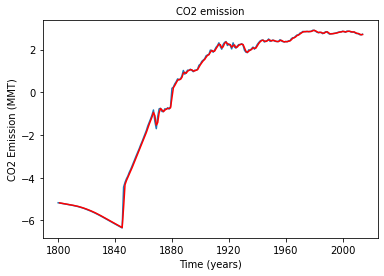

In [28]:
#As Exponential TransForm Data Gave least MAPE,So Will Visualize its Moving Average
moving_avg = Log_.CO2.rolling(2).mean()
plt.plot(Log_.CO2)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

Inference: So Far, The Best Model is Naive & Moving Average Model with Log Transformation which gave Least MAPE of 1.675075 & 1.802127 Respectively

In [29]:
#Simple Exponential Smoothing Model/Methods
def ses_model(train,test):
    fit_ = SimpleExpSmoothing(np.asarray(train['CO2'])).fit(smoothing_level=0.9,optimized=False)
    SES = fit_.forecast(len(test))
    result = np.mean(np.abs((SES-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_osesm = ses_model(Ori_train,Ori_test)
mape_lsesm = ses_model(Log_train,Log_test)
mape_rsesm = ses_model(Reci_train,Reci_test)
mape_ssesm = ses_model(Sqrt_train,Sqrt_test)
mape_bsesm = ses_model(Box_train,Box_test)
#Final Result Grid
Ses_result_grid = ['Simple Exp Smoothing', mape_osesm, mape_lsesm, mape_rsesm, mape_ssesm, mape_bsesm]
Result_df.loc[len(Result_df.index)] = Ses_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067
4,Simple Average,73.892246,131.961075,137792.336173,61.732583,96.683402
5,Moving Average,4.972519,1.802127,5.183939,2.510991,2.403927
6,Simple Exp Smoothing,4.742296,1.712167,4.890105,2.388077,2.285605


In [30]:
#Holt's Smoothing Model/Methods
def holt_model(train,test):
    fit_ = Holt(np.asarray(train['CO2'])).fit(smoothing_level = 0.1,smoothing_slope = 0.1)
    holt = fit_.forecast(len(test))
    result = np.mean(np.abs((holt-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_ohsm = holt_model(Ori_train,Ori_test)
mape_lhsm = holt_model(Log_train,Log_test)
mape_rhsm = holt_model(Reci_train,Reci_test)
mape_shsm = holt_model(Sqrt_train,Sqrt_test)
mape_bhsm = holt_model(Box_train,Box_test)
#Final Result Grid
Holt_result_grid = ['Holt Smoothing', mape_ohsm, mape_lhsm, mape_rhsm, mape_shsm, mape_bhsm]
Result_df.loc[len(Result_df.index)] = Holt_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067
4,Simple Average,73.892246,131.961075,137792.336173,61.732583,96.683402
5,Moving Average,4.972519,1.802127,5.183939,2.510991,2.403927
6,Simple Exp Smoothing,4.742296,1.712167,4.890105,2.388077,2.285605
7,Holt Smoothing,18.766422,10.030858,2788.653089,11.252373,12.181049


In [31]:
#Holt's Smoothing Model/Methods
def holt_winter(train,test):
    fit_ = ExponentialSmoothing(train['CO2']).fit()
    holtw = fit_.forecast(len(test))
    result = np.mean(np.abs((holtw-test.CO2)/test.CO2)*100)
    return result
#Calling Function for all Data 
mape_ohwm = holt_winter(Ori_train,Ori_test)
mape_lhwm = holt_winter(Log_train,Log_test)
mape_rhwm = holt_winter(Reci_train,Reci_test)
mape_shwm = holt_winter(Sqrt_train,Sqrt_test)
mape_bhwm = holt_winter(Box_train,Box_test)
#Final Result Grid
Holt_result_grid = ['Holt winter', mape_ohwm, mape_lhwm, mape_rhwm, mape_shwm, mape_bhwm]
Result_df.loc[len(Result_df.index)] = Holt_result_grid 
Result_df

,Model,Ori_MAPE,Log_MAPE,Reci_MAPE,Sqrt_MAPE,Box_MAPE
0,Linear Model,16.483920,108.404518,204300.419266,10.795550,46.136285
1,Exponential Model,64.469798,42.807310,9700.050232,28.047605,48.548968
2,Quadratic Model,23.150158,18.788091,52980.627821,24.870353,33.364613
3,Naive Model,4.649507,1.675075,4.766006,2.337979,2.237067
4,Simple Average,73.892246,131.961075,137792.336173,61.732583,96.683402
5,Moving Average,4.972519,1.802127,5.183939,2.510991,2.403927
6,Simple Exp Smoothing,4.742296,1.712167,4.890105,2.388077,2.285605
7,Holt Smoothing,18.766422,10.030858,2788.653089,11.252373,12.181049
8,Holt winter,4.694816,1.675075,4.766006,2.337979,2.237067


Inference: So Far,  The Best Model is Naive & Holts Winter Model with Log Transformation which gave Least MAPE of 1.675075 Respectively

#### Arima Models

#### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [32]:
#Original Data
ori_data= pd.read_excel("C:/Users/Akaash/Downloads/CO2 dataset.xlsx", header= 0, index_col=0, parse_dates=True,squeeze=True)
#Log Data
log_data = np.log(ori_data)
#Reci Data
reci_data = 1/(ori_data)
#Sqrt Data
sqrt_data = np.sqrt(ori_data)
#Box Data
box_data, param = stats.boxcox(ori_data)

In [33]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.20)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    mape = np.mean(np.abs((yhat-test)/test)*100)
    return mape

In [34]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mape = evaluate_arima_model(dataset, order)
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                    print('ARIMA%s MAPE=%.3f' % (order,mape))
                except:
                    continue
    print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))

In [35]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

In [36]:
#Grid Search Evaluate Arima For Original Data
Best = evaluate_models(ori_data.values, p_values, d_values, q_values)

Best ARIMANone MAPE=inf


In [37]:
#Grid Search Evaluate Arima For Log Data
evaluate_models(log_data.values, p_values, d_values, q_values)

Best ARIMANone MAPE=inf


In [38]:
#Grid Search Evaluate Arima For Reci Data
evaluate_models(reci_data.values, p_values, d_values, q_values)

Best ARIMANone MAPE=inf


In [39]:
#Grid Search Evaluate Arima For Sqrt Data
evaluate_models(sqrt_data.values, p_values, d_values, q_values)

Best ARIMANone MAPE=inf


In [40]:
#Grid Search Evaluate Arima For Box Data
Best = evaluate_models(box_data, p_values, d_values, q_values)

Best ARIMANone MAPE=inf


Inference: The Best Arima Model was of reciporal data with mape = 51.207, But the Best/Least mape we got is with Holts Winter  i.e 1.675075 So Our Final Model is Holts Winter

#### Final model - Holt Winter Smoothing (MAPE)

In [41]:
#Model
hw_model = ExponentialSmoothing(Log_['CO2'],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hw = hw_model.predict(start = Log_.index[0],end = Log_.index[-1])
tsd1['Forecast']=np.exp(pred_hw)
#Final Model Mape
final_mape = np.mean(np.abs((pred_hw-Log_.CO2)/Log_.CO2)*100)
final_mape

5.894838614449087

In [42]:
#Forecast
tsd1

,CO2,Forecast
Year,,
1800-01-01,0.00568,0.005681
1801-01-01,0.00561,0.005349
1802-01-01,0.00555,0.005551
1803-01-01,0.00548,0.005688
1804-01-01,0.00542,0.005473
...,...,...
2010-01-01,15.60000,15.487164
2011-01-01,15.60000,15.610964
2012-01-01,14.80000,15.811241


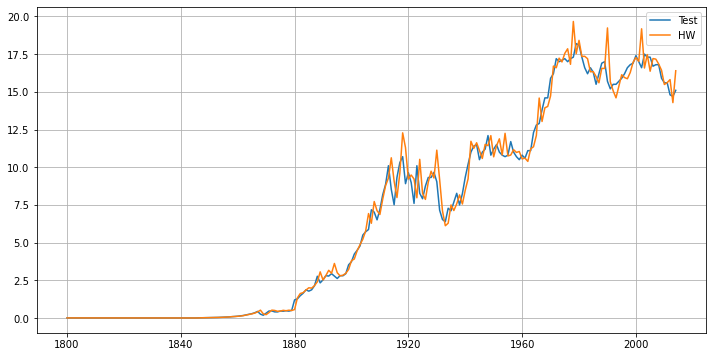

In [43]:
#Forecasted Data Line 
plt.figure(figsize=(12,6))
plt.plot(tsd1['CO2'], label='Test')
plt.plot(tsd1['Forecast'], label='HW')
plt.legend(loc='best')
plt.grid()
plt.show()

#### Forecast for 10 years

In [44]:
future_dates_10 = [tsd1.index[-1] + DateOffset(years=x)for x in range(0,11)]
future_df_10 = pd.DataFrame(index=future_dates_10[1:],columns=tsd1.columns)
future_df_10 = future_df_10.drop(['Forecast'], axis = 'columns')
future_df_10.index.name = "Year"
future_df_10.shape

(10, 1)

In [45]:
#Predicting
next_10 = hw_model.forecast(10)
future_df_10['CO2']= np.exp(next_10)
#Printing the DF
future_df_10

,CO2
Year,
2015-01-01,14.976164
2016-01-01,14.791402
2017-01-01,13.853309
2018-01-01,13.587498
2019-01-01,13.804055
2020-01-01,13.701170
2021-01-01,13.266196
2022-01-01,12.820284
2023-01-01,12.722137


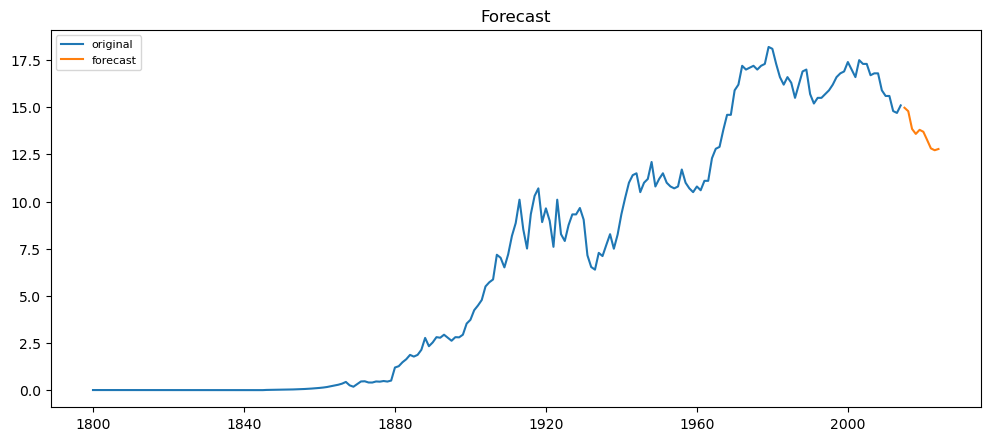

In [46]:
#Original Data
tsd2 = tsd1.drop(['Forecast'], axis='columns')
#Plotting the Forecasted Data of Next 10 Years
plt.figure(figsize=(12,5), dpi=100)
plt.plot(tsd2, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Saving the Forecasted Data for the Next 10 Years in CSV

In [47]:
# Exporting to csv file
future_df_10.to_csv(r'C:/Users/Akaash/Downloads/forecast_data_10years.csv',index=True)

#### Saving the Trained Model

In [48]:
# .sav file
import pickle
filename = 'C:/Users/Akaash/Downloads/air_quality_forecast.sav'
pickle.dump(hw_model, open(filename, 'wb'))

In [49]:
# .pickle file
with open('C:/Users/Akaash/Downloads/air_quality_forecasts.pickle','wb') as f:
    pickle.dump(hw_model,f)

#### Saving for Deployment

In [50]:
final_df = tsd1.drop(['Forecast'],axis="columns")
#For Deployment
final_df.to_pickle("C:/Users/Akaash/Downloads/air_final_df.pickle")
final_df.to_csv("C:/Users/Akaash/Downloads/CO2_Cleaned_data.csv")